Склонность клиентов к продуктам

In [1]:
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, balanced_accuracy_score, roc_auc_score,
                             roc_curve, auc, log_loss)

Функция обучения модели:

In [5]:
def train_catboost_model(X_train, y_train, X_test, y_test,  cat_features, 
                         iterations=500, depth=9, learning_rate=0.035, 
                         task_type="GPU", verbose=250):
    """
    Обучает модель CatBoost для данного таргета и возвращает её.
    
    Параметры:
      X_train: DataFrame или array-like, обучающие признаки.
      y_train: Series или array-like, целевая переменная.
      cat_features: список названий категориальных признаков.
      iterations, depth, learning_rate, task_type, verbose: параметры CatBoost.
      
    Возвращает:
      Обученную модель CatBoostClassifier.
    """
    model = cb.CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='Logloss',
        cat_features=cat_features,
        task_type=task_type,
        verbose=verbose
    )
    model.fit(X_train, y_train, eval_set=(X_test, y_test)) 
    return model

Функция для оценки качества модели

In [6]:
def evaluate_catboost_model(model, X_test, y_test, feature_names=None):
    """
    Вычисляет метрики классификации по модели CatBoost, строит ROC-кривую и график важности признаков.
    
    Параметры:
      model: обученная модель CatBoost.
      X_test: тестовые признаки (DataFrame или array-like).
      y_test: истинные метки тестовой выборки.
      feature_names: (опционально) список названий признаков.
      
    Возвращает:
      metrics: словарь с метриками (accuracy, precision, recall, f1, balanced_accuracy, auc, logloss).
      fi_df: DataFrame с важностью признаков.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_pred_proba),
        "logloss": log_loss(y_test, y_pred_proba)
    }
    
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"LogLoss: {metrics['logloss']:.4f}")
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc_val:.4f})")
    plt.plot([0,1], [0,1], color="grey", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    # importances = model.get_feature_importance()
    # if feature_names is None:
    #     try:
    #         feature_names = X_test.columns
    #     except AttributeError:
    #         feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
    # fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    # fi_df = fi_df.sort_values(by="Importance", ascending=False)
    
    # plt.figure(figsize=(10,6))
    # plt.barh(fi_df["Feature"], fi_df["Importance"], color="skyblue")
    # plt.gca().invert_yaxis()
    # plt.xlabel("Importance")
    # plt.title("Feature Importance")
    # plt.show()
    
    return metrics

In [8]:

data = pd.read_csv("../../Data/known_behaviors_data.csv")

target_cols = ["Mortgage", "Pension", "Savings"]

customer_ids = data["customer_id"]

def prepare_data_for_target(df, target, id_col="customer_id"):
    feature_cols = [col for col in df.columns if col not in [id_col] + target_cols]
    X = df[feature_cols]
    y = df[target]
    return X, y

target_cols = ["Mortgage", "Pension", "Savings"]

cat_features = ["gender", "bad_payment", "gold_card", "pension_plan"]

models = {}
metrics_dict = {}
fi_dict = {}

# for target in target_cols:
#     print(f"\n===== Обучение модели для таргета: {target} ======")
#     X, y = prepare_data_for_target(data, target)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     model = train_catboost_model(X_train, y_train, X_test, y_test, cat_features)
#     models[target] = model
    
#     print(f"\nМетрики для модели {target}:")
#     metrics, fi_df = evaluate_catboost_model(model, X_test, y_test, feature_names=X.columns)
#     print(f"\n Это были feature importance для {target}:")
#     metrics_dict[target] = metrics
#     fi_dict[target] = fi_df

In [ ]:
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split

target_cols = ["Mortgage", "Pension", "Savings"]
data_path = "../../Data/splited-data/"  


def train_catboost_model(X_train, y_train, X_test, y_test, cat_features):
    model = cb.CatBoostClassifier(
        iterations=500,
        depth=9,
        learning_rate=0.035,
        loss_function='Logloss',
        cat_features=cat_features,
        task_type="GPU",
        verbose=0
    )
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    return model

def train_xgboost(X_train, y_train, X_val, y_val):
    model = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        use_label_encoder=False,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    return model

def train_lightgbm(X_train, y_train, X_val, y_val):
    model = lgb.LGBMClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        device="gpu"
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="logloss")
    return model

all_models = {}

for target in target_cols:
    print(f"\n===== Обучение моделей для {target} =====")

    train_data = pd.read_csv(f"{data_path}train_{target}.csv")
    val_data = pd.read_csv(f"{data_path}val_{target}.csv")

    X_train = train_data.drop(columns=[target])
    y_train = train_data[target]
    X_val = val_data.drop(columns=[target])
    y_val = val_data[target]

    cat_model = train_catboost_model(X_train, y_train, X_val, y_val, cat_features)
    xgb_model = train_xgboost(X_train, y_train, X_val, y_val)
    lgb_model = train_lightgbm(X_train, y_train, X_val, y_val)

    all_models[target] = {
        "CatBoost": (cat_model, X_val),
        "XGBoost": (xgb_model, X_val),
        "LightGBM": (lgb_model, X_val)
    }

with PdfPages("shap_feature_importance_all_models.pdf") as pdf:
    for target, model_dict in all_models.items():
        for model_name, (model, data) in model_dict.items():
            print(f"Создаю SHAP графики: {target} — {model_name}")
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(data)

            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, data, plot_type="bar", show=False)
            plt.title(f"{target} — {model_name} — SHAP (Bar)")
            pdf.savefig(bbox_inches="tight")
            plt.close()

            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, data, show=False)
            plt.title(f"{target} — {model_name} — SHAP (Summary)")
            pdf.savefig(bbox_inches="tight")
            plt.close()

print(" SHAP-графики сохранены в файл: shap_feature_importance_all_models.pdf")


In [14]:
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from functools import reduce

target_cols = ["Mortgage", "Pension", "Savings"]

preds_dict = []

def train_catboost(X_train, y_train, X_val, y_val, cat_features):
    model = cb.CatBoostClassifier(
        iterations=500, depth=6, learning_rate=0.1, 
        random_seed=42, task_type="GPU", devices="0",
        verbose=False
    )
    model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))
    return model

data = pd.read_csv("../../Data/known_behaviors_data.csv")


customer_id = data["customer_id"]

X = data.drop(columns=target_cols + ["customer_id"])  
y = data[target_cols] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

cat_features = [i for i in range(X_train.shape[1]) if X_train.dtypes.iloc[i] == "object"]

for target in target_cols:
    y_train_target = y_train[target]
    y_val_target = y_val[target]

    model = train_catboost(X_train, y_train_target, X_val, y_val_target, cat_features)

    preds = model.predict_proba(X_val)[:, 1]

    df = pd.DataFrame({
        "customer_id": customer_id.iloc[X_val.index], 
        target: preds
    })
    preds_dict.append(df)

val_df = reduce(lambda left, right: pd.merge(left, right, on="customer_id", how="outer"), preds_dict)

val_df.fillna(val_df.median(), inplace=True)

val_df.to_csv("predictions.csv", index=False)




===== Обучение модели для Mortgage =====

 LightGBM (GPU):
Accuracy: 0.7658
Precision: 0.9116
Recall: 0.5886
F1-score: 0.7153
Balanced Accuracy: 0.7658
AUC: 0.9354
LogLoss: 0.5834


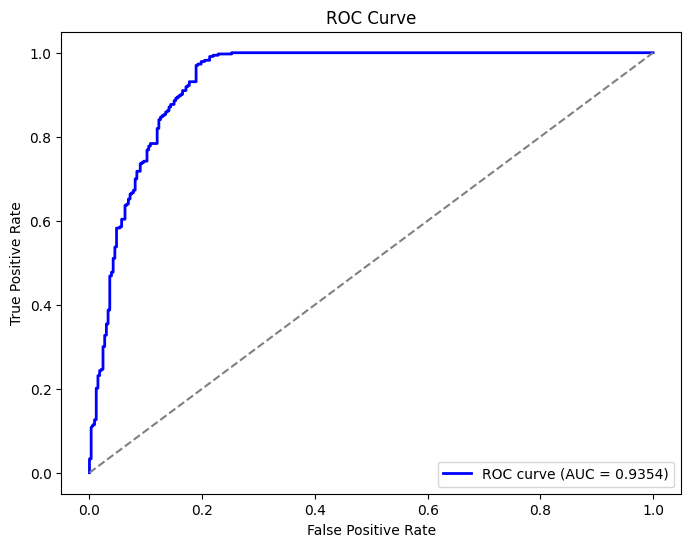


===== Обучение модели для Pension =====

 LightGBM (GPU):
Accuracy: 0.5662
Precision: 0.7044
Recall: 0.2281
F1-score: 0.3446
Balanced Accuracy: 0.5662
AUC: 0.7274
LogLoss: 0.9150


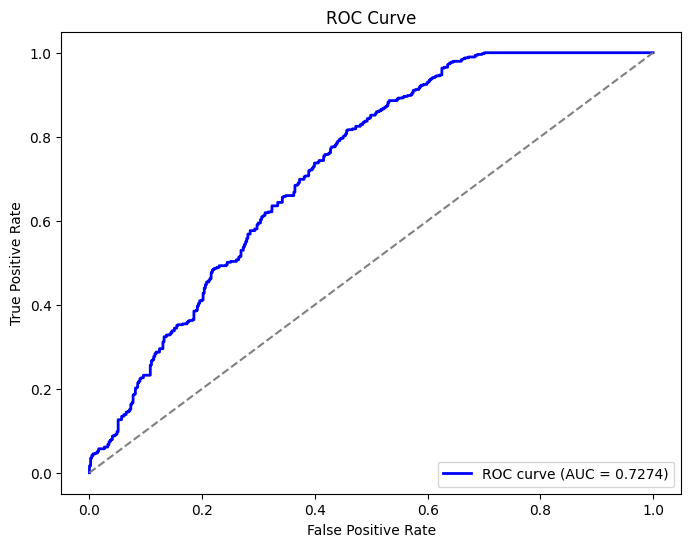


===== Обучение модели для Savings =====

 LightGBM (GPU):
Accuracy: 0.5746
Precision: 0.6105
Recall: 0.4118
F1-score: 0.4919
Balanced Accuracy: 0.5746
AUC: 0.6429
LogLoss: 0.7387


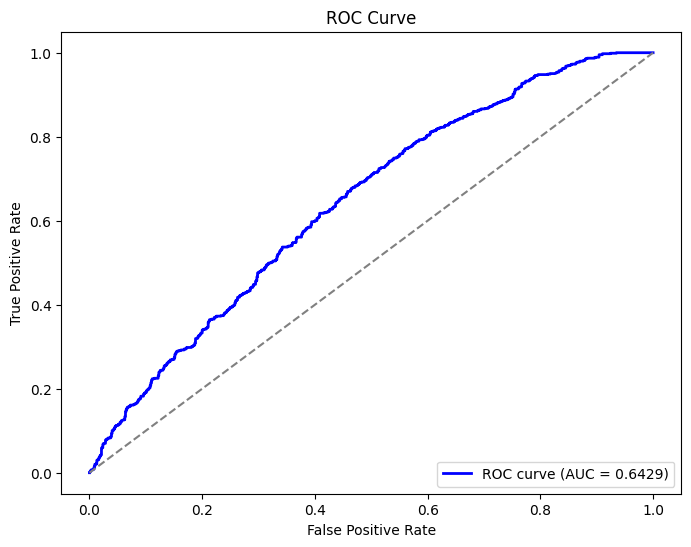


===== Результаты для Mortgage =====

 LightGBM:
accuracy: 0.7658
precision: 0.9116
recall: 0.5886
f1: 0.7153
balanced_accuracy: 0.7658
auc: 0.9354
logloss: 0.5834

===== Результаты для Pension =====

 LightGBM:
accuracy: 0.5662
precision: 0.7044
recall: 0.2281
f1: 0.3446
balanced_accuracy: 0.5662
auc: 0.7274
logloss: 0.9150

===== Результаты для Savings =====

 LightGBM:
accuracy: 0.5746
precision: 0.6105
recall: 0.4118
f1: 0.4919
balanced_accuracy: 0.5746
auc: 0.6429
logloss: 0.7387


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import log_loss

def train_lightgbm(X_train, y_train, X_val, y_val):
    model = lgb.LGBMClassifier(
        n_estimators=500, 
        max_depth=6, 
        learning_rate=0.1, 
        random_state=42, 
        device="gpu"
    )
    model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)], 
        eval_metric="logloss", 
    )
    return model

results = {}

for target in target_cols:
    print(f"\n===== Обучение модели для {target} =====")

    train_data = pd.read_csv(f"../../Data/splited-data/train_{target}.csv")
    val_data = pd.read_csv(f"../../Data/splited-data/val_{target}.csv")

    X_train = train_data.drop(columns=[target])
    y_train = train_data[target]
    X_val = val_data.drop(columns=[target])
    y_val = val_data[target]

    print("\n LightGBM (GPU):")
    model = train_lightgbm(X_train, y_train, X_val, y_val)

    lightgbm_metrics = evaluate_catboost_model(model, X_val, y_val, feature_names=X_train.columns)

    results[target] = {"LightGBM": lightgbm_metrics}

for target, metrics in results.items():
    print(f"\n===== Результаты для {target} =====")
    print(f"\n LightGBM:")
    for metric, value in metrics["LightGBM"].items():
        print(f"{metric}: {value:.4f}")



===== Обучение моделей для Mortgage =====

LightGBM (GPU)... Accuracy: 0.7658
Precision: 0.9116
Recall: 0.5886
F1-score: 0.7153
Balanced Accuracy: 0.7658
AUC: 0.9354
LogLoss: 0.5834


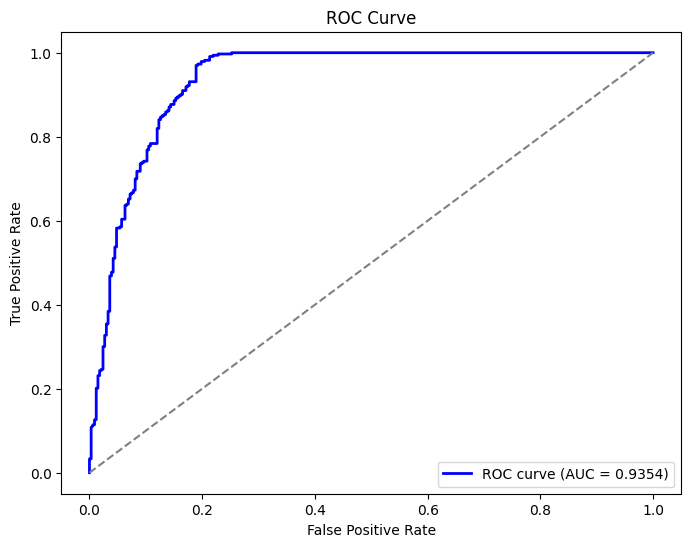

Готово!

XGBoost (GPU)... 

c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:51:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:51:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7763
Precision: 0.9035
Recall: 0.6186
F1-score: 0.7344
Balanced Accuracy: 0.7763
AUC: 0.9370
LogLoss: 0.5242


c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [01:51:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:729: UserWarning: [01:51:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only b

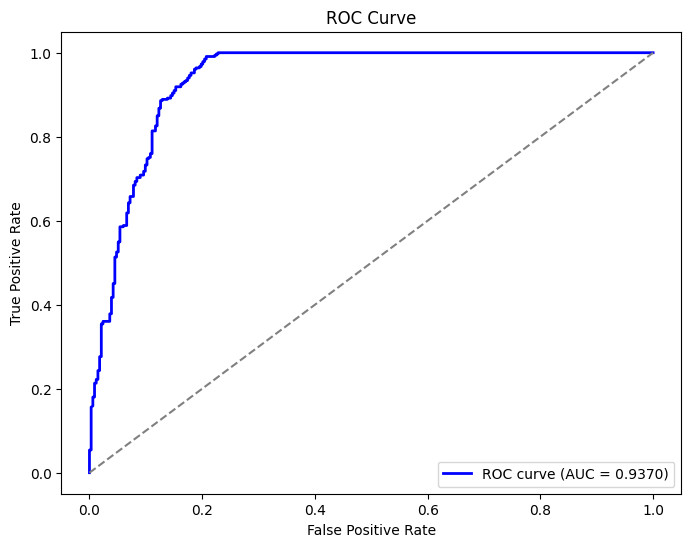

Готово!

CatBoost (GPU)... Accuracy: 0.7913
Precision: 0.9217
Recall: 0.6366
F1-score: 0.7531
Balanced Accuracy: 0.7913
AUC: 0.9438
LogLoss: 0.3944


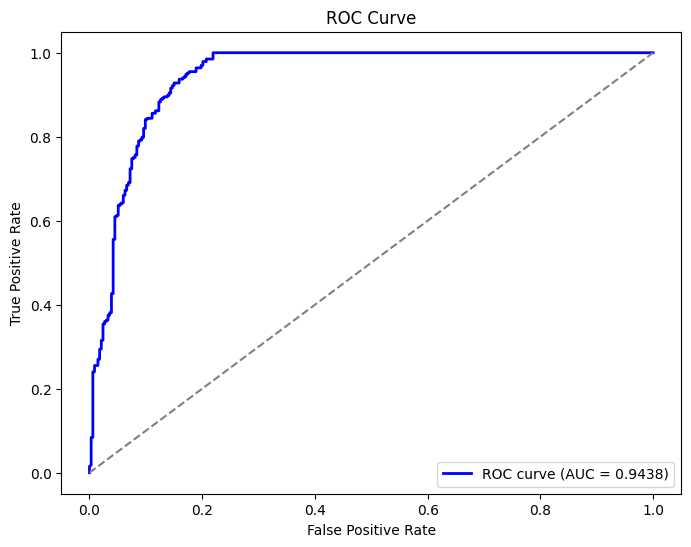

Готово!

===== Обучение моделей для Pension =====

LightGBM (GPU)... Accuracy: 0.5662
Precision: 0.7044
Recall: 0.2281
F1-score: 0.3446
Balanced Accuracy: 0.5662
AUC: 0.7274
LogLoss: 0.9150


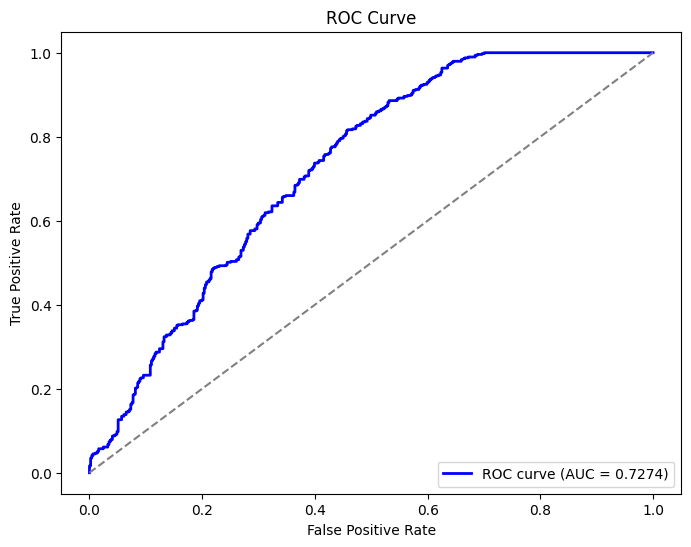

Готово!

XGBoost (GPU)... 

c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:52:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:52:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [01:52:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to C

Accuracy: 0.5652
Precision: 0.7051
Recall: 0.2240
F1-score: 0.3400
Balanced Accuracy: 0.5652
AUC: 0.7390
LogLoss: 0.8819


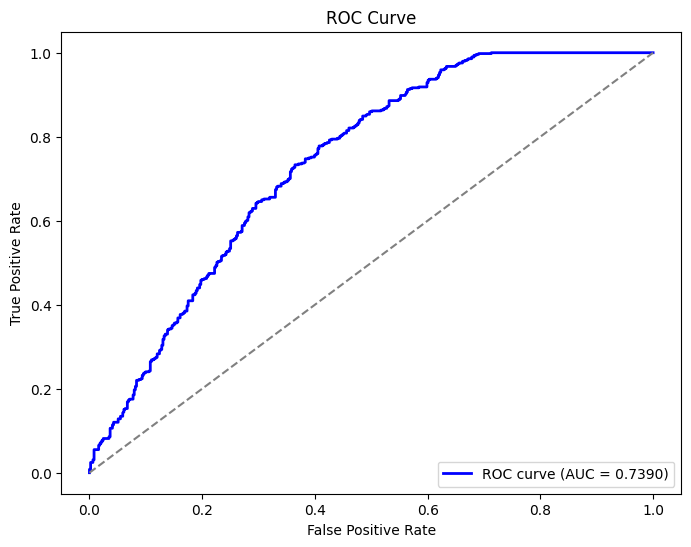

Готово!

CatBoost (GPU)... Accuracy: 0.5458
Precision: 0.8947
Recall: 0.1039
F1-score: 0.1861
Balanced Accuracy: 0.5458
AUC: 0.7789
LogLoss: 0.6298


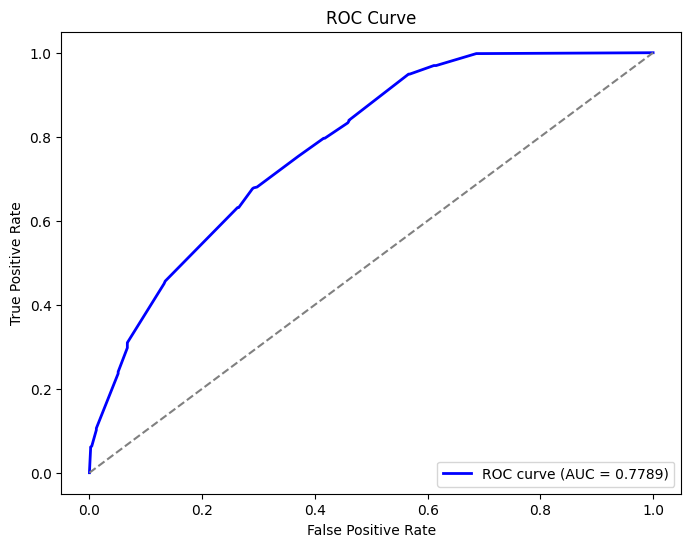

Готово!

===== Обучение моделей для Savings =====

LightGBM (GPU)... Accuracy: 0.5734
Precision: 0.6092
Recall: 0.4095
F1-score: 0.4897
Balanced Accuracy: 0.5734
AUC: 0.6428
LogLoss: 0.7389


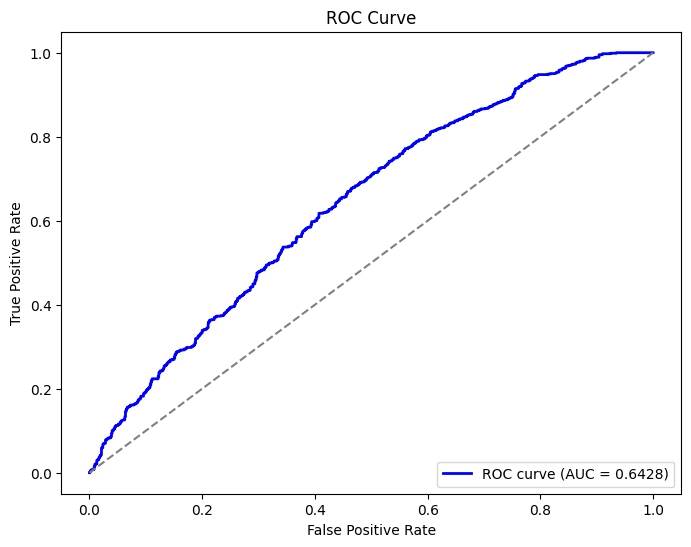

Готово!

XGBoost (GPU)... 

c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:52:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:52:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.5651
Precision: 0.5993
Recall: 0.3929
F1-score: 0.4746
Balanced Accuracy: 0.5651
AUC: 0.6332
LogLoss: 0.7513


c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:2676: UserWarning: [01:52:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


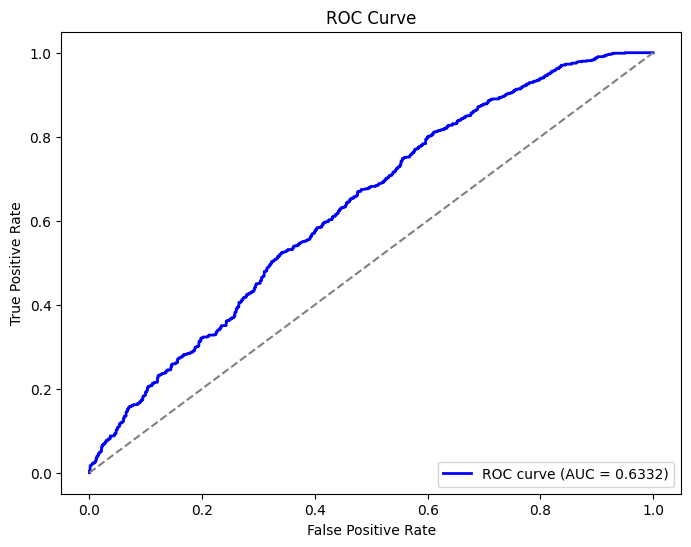

Готово!

CatBoost (GPU)... Accuracy: 0.5734
Precision: 0.6962
Recall: 0.2604
F1-score: 0.3790
Balanced Accuracy: 0.5734
AUC: 0.6925
LogLoss: 0.6493


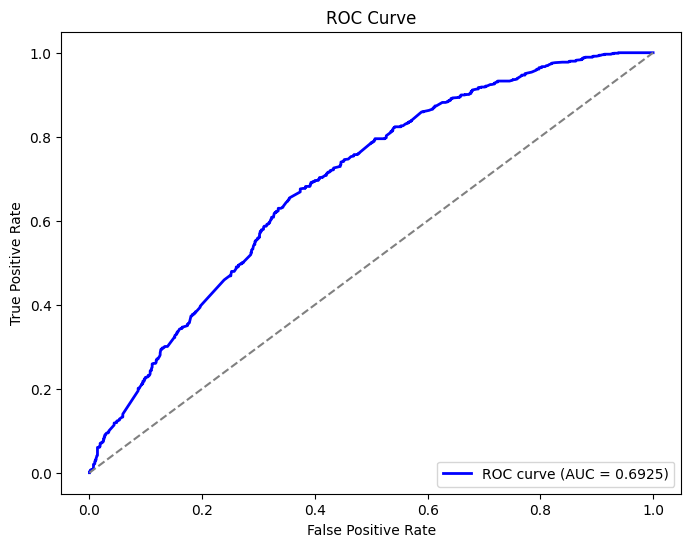

Готово!

===== Сравнение моделей для Mortgage =====

LightGBM:
train_time: 3.9690
peak_memory: 4.7967

XGBoost:
train_time: 2.4453
peak_memory: 0.7133

CatBoost:
train_time: 20.7108
peak_memory: 0.0629

===== Сравнение моделей для Pension =====

LightGBM:
train_time: 3.6660
peak_memory: 4.4061

XGBoost:
train_time: 2.0720
peak_memory: 0.6956

CatBoost:
train_time: 19.8150
peak_memory: 0.0508

===== Сравнение моделей для Savings =====

LightGBM:
train_time: 3.6940
peak_memory: 4.2662

XGBoost:
train_time: 2.0905
peak_memory: 0.6960

CatBoost:
train_time: 19.9219
peak_memory: 0.0510


In [ ]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
import time
import tracemalloc
import warnings

warnings.filterwarnings("ignore", category=FutureWarning) 

def train_lightgbm(X_train, y_train, X_val, y_val):
    model = lgb.LGBMClassifier(
        n_estimators=500, 
        max_depth=6, 
        learning_rate=0.1, 
        random_state=42, 
        device="gpu"
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="logloss")
    return model

def train_xgboost(X_train, y_train, X_val, y_val):
    model = xgb.XGBClassifier(
        n_estimators=500, 
        max_depth=6, 
        learning_rate=0.1, 
        use_label_encoder=False, 
        eval_metric="logloss",
        random_state=42, 
        tree_method="gpu_hist"
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    return model

def train_catboost(X_train, y_train, X_val, y_val, cat_features):
    model = CatBoostClassifier(
        iterations=500, depth=6, learning_rate=0.1, 
        random_seed=42, task_type="GPU", devices="0",
        verbose=False
    )
    model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))
    return model

results = {}

for target in target_cols:
    print(f"\n===== Обучение моделей для {target} =====")

    train_data = pd.read_csv(f"../../Data/splited-data/train_{target}.csv")
    val_data = pd.read_csv(f"../../Data/splited-data/val_{target}.csv")

    X_train = train_data.drop(columns=[target])
    y_train = train_data[target]
    X_val = val_data.drop(columns=[target])
    y_val = val_data[target]
    cat_features = [i for i in range(X_train.shape[1]) if X_train.dtypes[i] == "object"]

    model_metrics = {}

    for model_name, train_func in [("LightGBM", train_lightgbm), ("XGBoost", train_xgboost)]:
        print(f"\n{model_name} (GPU)...", end=" ")
        tracemalloc.start()
        start_time = time.time()
        model = train_func(X_train, y_train, X_val, y_val)
        train_time = time.time() - start_time
        _, peak_memory = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        metrics = evaluate_catboost_model(model, X_val, y_val, feature_names=X_train.columns)
        metrics["train_time"] = train_time
        metrics["peak_memory"] = peak_memory / 1024**2 
        model_metrics[model_name] = metrics
        print("Готово!")

    print("\nCatBoost (GPU)...", end=" ")
    tracemalloc.start()
    start_time = time.time()
    catboost_model = train_catboost(X_train, y_train, X_val, y_val, cat_features)
    train_time = time.time() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    catboost_metrics = evaluate_catboost_model(catboost_model, X_val, y_val, feature_names=X_train.columns)
    catboost_metrics["train_time"] = train_time
    catboost_metrics["peak_memory"] = peak_memory / 1024**2 
    model_metrics["CatBoost"] = catboost_metrics
    print("Готово!")

    results[target] = model_metrics

for target, models_metrics in results.items():
    print(f"\n===== Сравнение моделей для {target} =====")
    for model_name, metrics in models_metrics.items():
        print(f"\n{model_name}:")
        for metric, value in metrics.items():
            if metric in ["train_time", "peak_memory", "AUC", "LogLoss"]: 
                print(f"{metric}: {value:.4f}")


Наконец, используйте полученную матрицу весов в качестве матрицы в векторными представлениями слов. Рекомендуем использовать для сдачи матрицу, которая отвечала за слова из контекста (т.е. декодера).


===== Эксперименты для Mortgage =====

CatBoost на PCA (5 компонентов):
0:	learn: 0.6724758	test: 0.6716012	best: 0.6716012 (0)	total: 41.7ms	remaining: 20.8s
250:	learn: 0.3943507	test: 0.4055177	best: 0.4036854 (108)	total: 17.6s	remaining: 17.5s
499:	learn: 0.3858983	test: 0.4074134	best: 0.4036854 (108)	total: 29.8s	remaining: 0us
bestTest = 0.4036854162
bestIteration = 108
Shrink model to first 109 iterations.
Accuracy: 0.8599
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Balanced Accuracy: 0.5000
AUC: 0.5613
LogLoss: 0.4037


c:\Users\syrov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


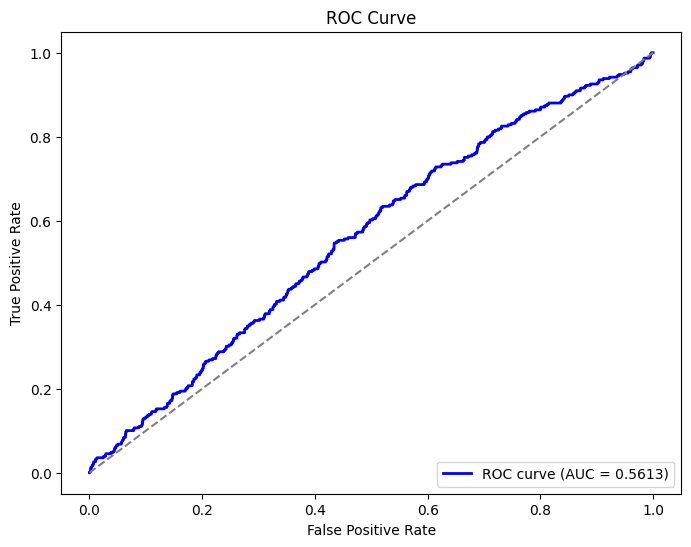

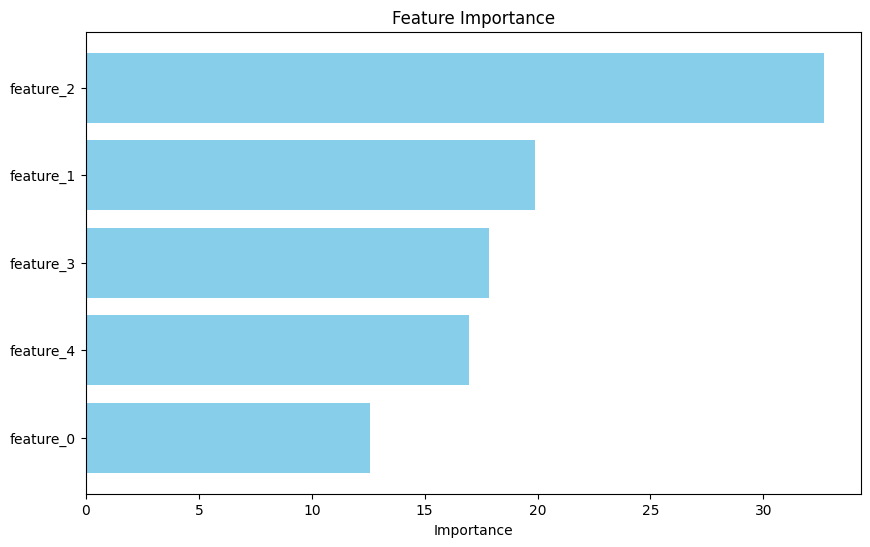


CatBoost на PCA (10 компонентов):
0:	learn: 0.6683607	test: 0.6673959	best: 0.6673959 (0)	total: 48.7ms	remaining: 24.3s
250:	learn: 0.3385589	test: 0.3697377	best: 0.3695459 (236)	total: 23.6s	remaining: 23.4s
499:	learn: 0.3039293	test: 0.3697880	best: 0.3691850 (303)	total: 45.6s	remaining: 0us
bestTest = 0.3691849966
bestIteration = 303
Shrink model to first 304 iterations.
Accuracy: 0.8590
Precision: 0.4167
Recall: 0.0162
F1-score: 0.0312
Balanced Accuracy: 0.5062
AUC: 0.7094
LogLoss: 0.3692


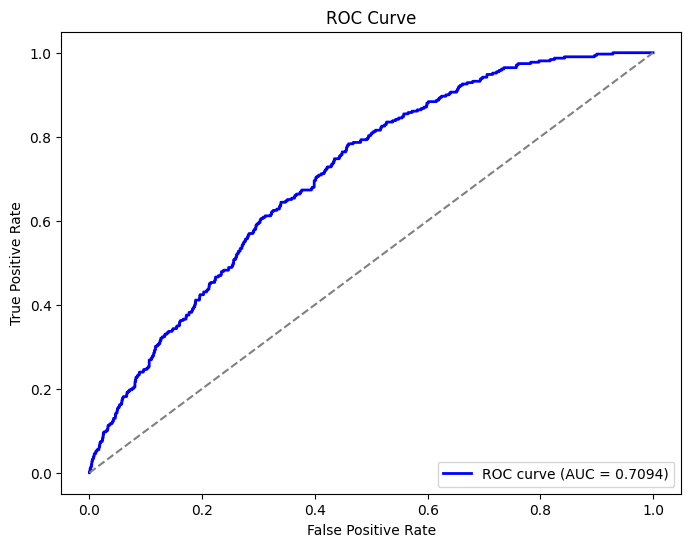

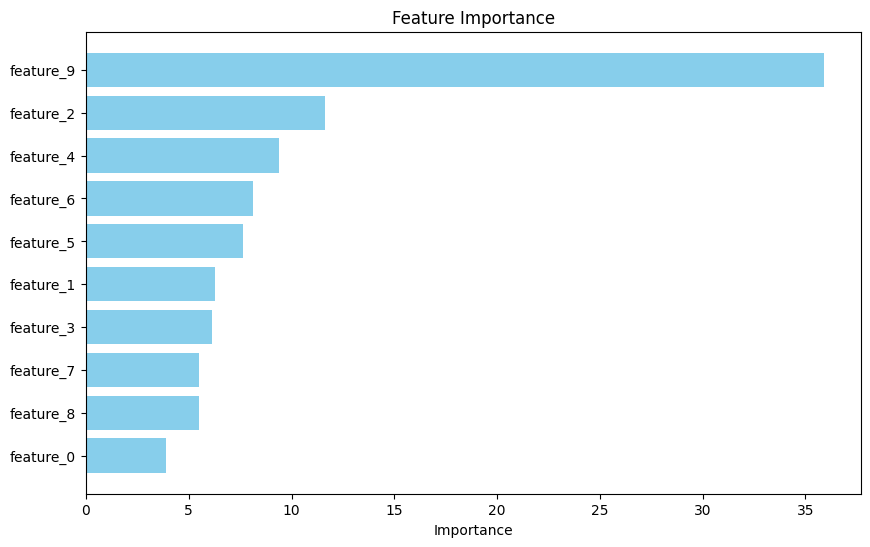


CatBoost после удаления слабых фичей:
0:	learn: 0.6115941	test: 0.6102656	best: 0.6102656 (0)	total: 129ms	remaining: 1m 4s
250:	learn: 0.1672001	test: 0.1953955	best: 0.1948817 (176)	total: 24.8s	remaining: 24.6s
499:	learn: 0.1439093	test: 0.1998619	best: 0.1948817 (176)	total: 56.1s	remaining: 0us
bestTest = 0.1948817385
bestIteration = 176
Shrink model to first 177 iterations.
Accuracy: 0.8989
Precision: 0.6503
Recall: 0.6019
F1-score: 0.6252
Balanced Accuracy: 0.7746
AUC: 0.9446
LogLoss: 0.1949


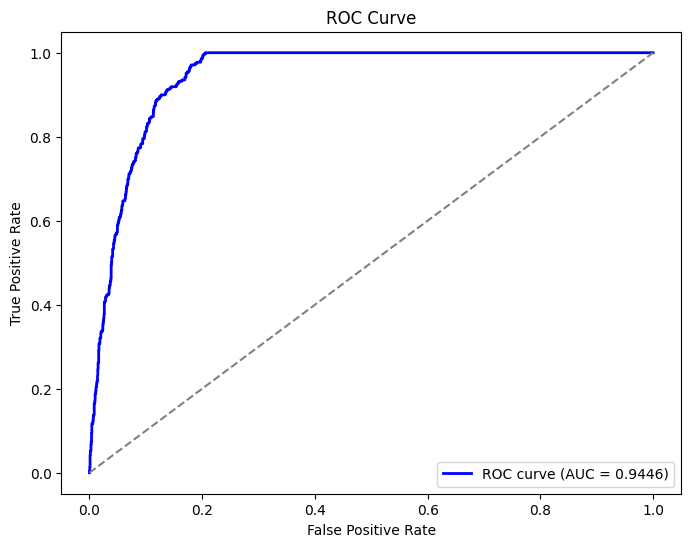

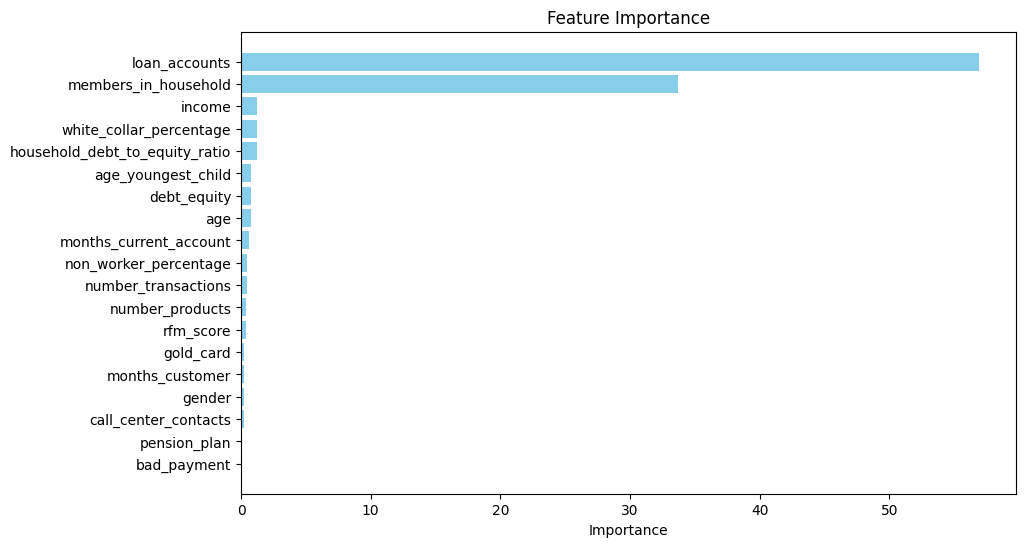


===== Эксперименты для Pension =====

CatBoost на PCA (5 компонентов):
0:	learn: 0.6677000	test: 0.6682328	best: 0.6682328 (0)	total: 37ms	remaining: 18.5s
250:	learn: 0.3958780	test: 0.4430419	best: 0.4400697 (94)	total: 20.3s	remaining: 20.1s
499:	learn: 0.3748544	test: 0.4487497	best: 0.4400697 (94)	total: 42.3s	remaining: 0us
bestTest = 0.4400697323
bestIteration = 94
Shrink model to first 95 iterations.
Accuracy: 0.7732
Precision: 0.4783
Recall: 0.0887
F1-score: 0.1497
Balanced Accuracy: 0.5303
AUC: 0.7674
LogLoss: 0.4401


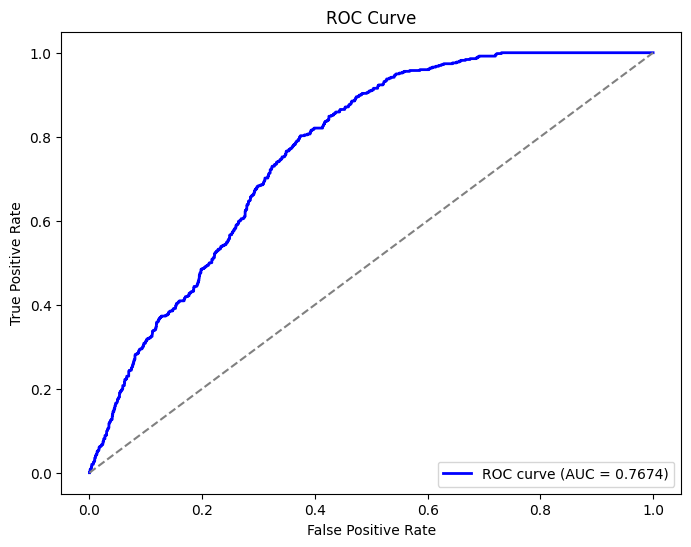

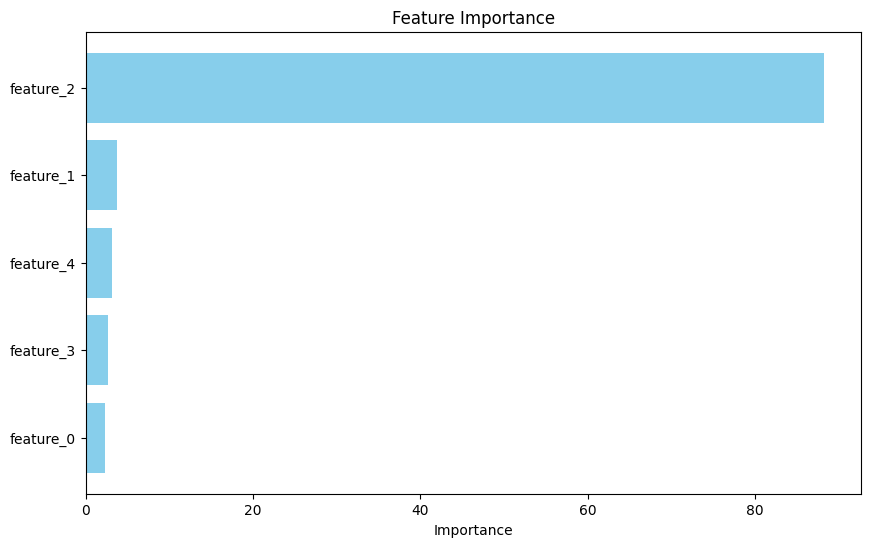


CatBoost на PCA (10 компонентов):
0:	learn: 0.6650450	test: 0.6659641	best: 0.6659641 (0)	total: 36.9ms	remaining: 18.4s
250:	learn: 0.3694728	test: 0.4457104	best: 0.4412694 (97)	total: 27.6s	remaining: 27.3s
499:	learn: 0.3277072	test: 0.4530587	best: 0.4412694 (97)	total: 57.7s	remaining: 0us
bestTest = 0.4412694261
bestIteration = 97
Shrink model to first 98 iterations.
Accuracy: 0.7701
Precision: 0.4444
Recall: 0.0887
F1-score: 0.1479
Balanced Accuracy: 0.5283
AUC: 0.7664
LogLoss: 0.4413


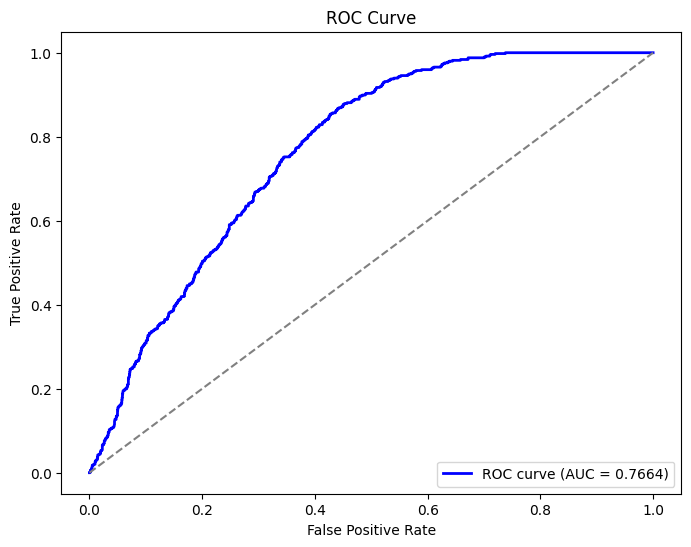

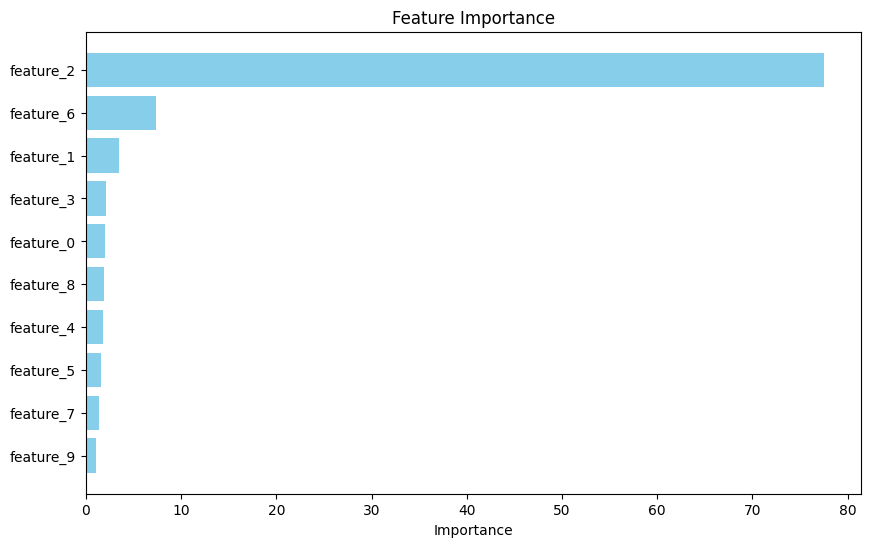


CatBoost после удаления слабых фичей:
0:	learn: 0.6670346	test: 0.6675562	best: 0.6675562 (0)	total: 129ms	remaining: 1m 4s
250:	learn: 0.3854275	test: 0.4411280	best: 0.4375468 (90)	total: 28s	remaining: 27.8s
499:	learn: 0.3574251	test: 0.4475636	best: 0.4375468 (90)	total: 59.2s	remaining: 0us
bestTest = 0.4375468351
bestIteration = 90
Shrink model to first 91 iterations.
Accuracy: 0.7751
Precision: 0.5000
Recall: 0.0806
F1-score: 0.1389
Balanced Accuracy: 0.5286
AUC: 0.7711
LogLoss: 0.4375


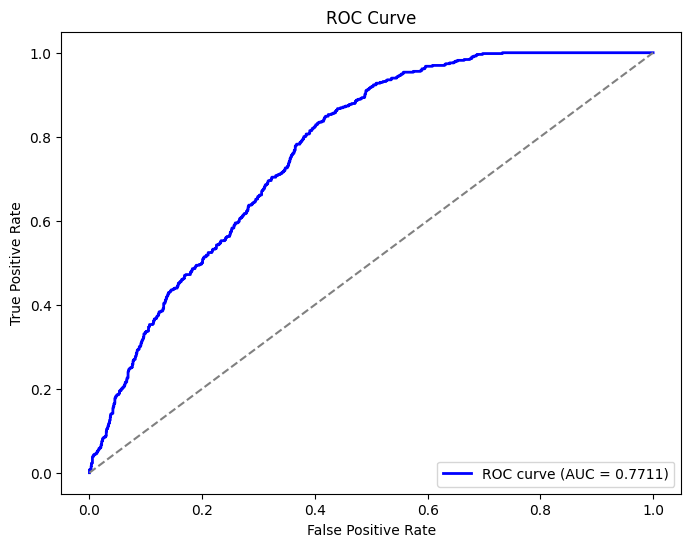

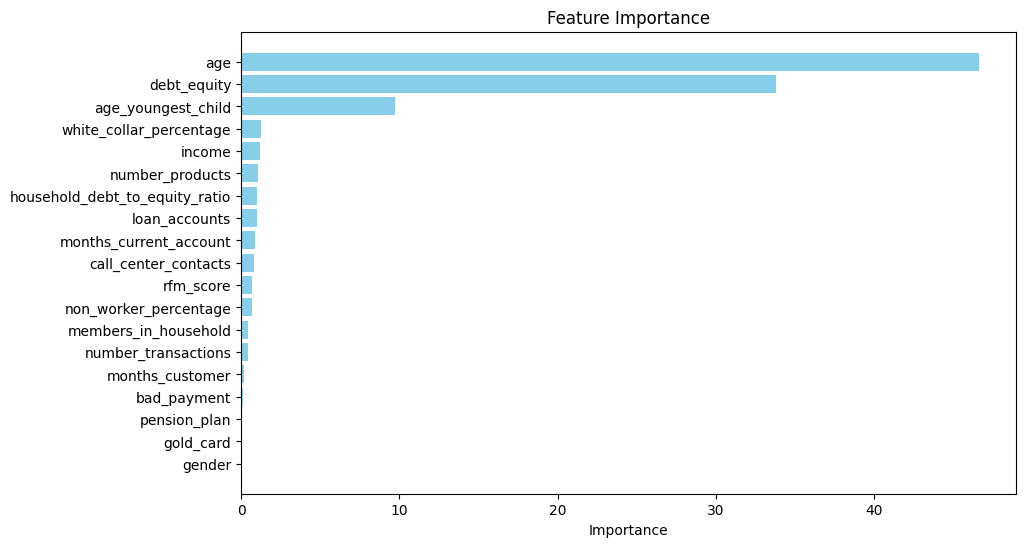


===== Эксперименты для Savings =====

CatBoost на PCA (5 компонентов):
0:	learn: 0.6862658	test: 0.6861699	best: 0.6861699 (0)	total: 36.8ms	remaining: 18.4s
250:	learn: 0.5783026	test: 0.6103229	best: 0.6081828 (87)	total: 17.8s	remaining: 17.7s
499:	learn: 0.5695518	test: 0.6118958	best: 0.6081828 (87)	total: 30.8s	remaining: 0us
bestTest = 0.6081828076
bestIteration = 87
Shrink model to first 88 iterations.
Accuracy: 0.6231
Precision: 0.5397
Recall: 0.2369
F1-score: 0.3293
Balanced Accuracy: 0.5537
AUC: 0.6831
LogLoss: 0.6082


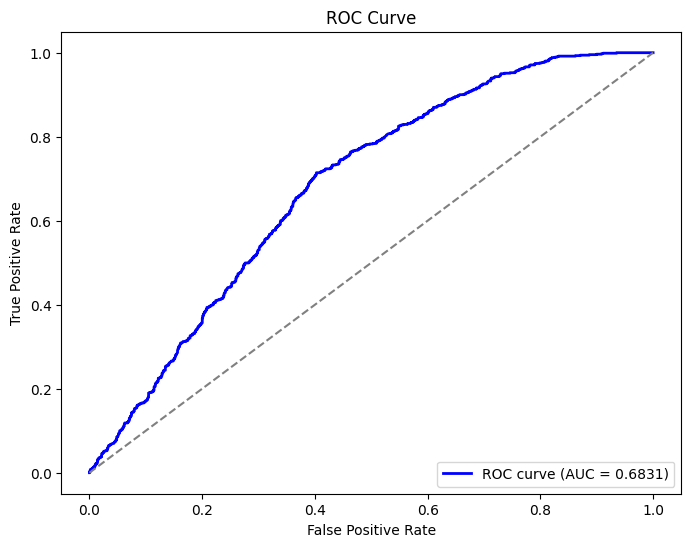

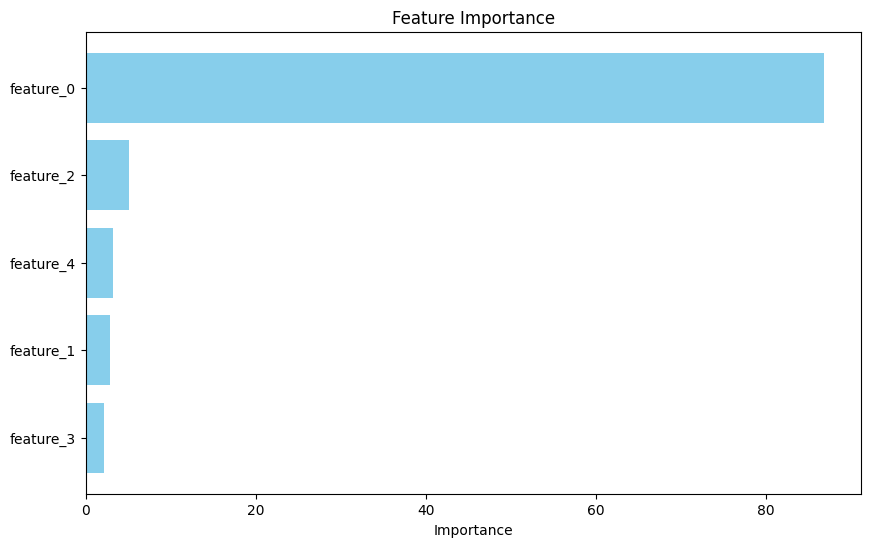


CatBoost на PCA (10 компонентов):
0:	learn: 0.6861962	test: 0.6861200	best: 0.6861200 (0)	total: 36.7ms	remaining: 18.3s
250:	learn: 0.5502996	test: 0.6112992	best: 0.6078050 (82)	total: 24.1s	remaining: 23.9s
499:	learn: 0.5210020	test: 0.6167138	best: 0.6078050 (82)	total: 45.6s	remaining: 0us
bestTest = 0.6078050263
bestIteration = 82
Shrink model to first 83 iterations.
Accuracy: 0.6231
Precision: 0.5362
Recall: 0.2578
F1-score: 0.3482
Balanced Accuracy: 0.5575
AUC: 0.6834
LogLoss: 0.6078


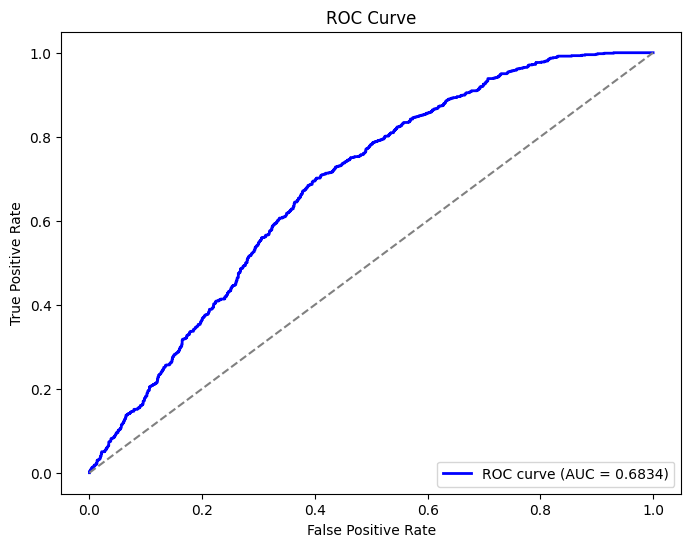

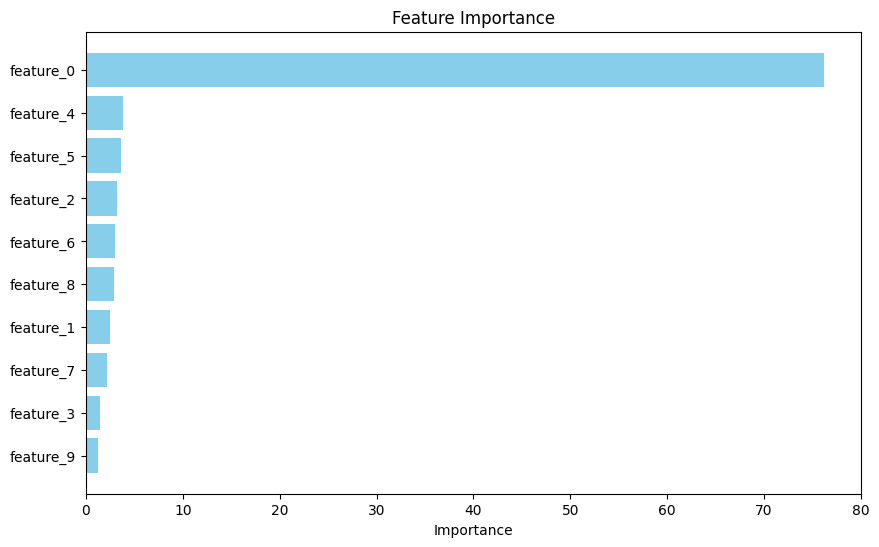


CatBoost после удаления слабых фичей:
0:	learn: 0.6850591	test: 0.6854009	best: 0.6854009 (0)	total: 129ms	remaining: 1m 4s
250:	learn: 0.5717060	test: 0.6149788	best: 0.6097554 (55)	total: 24.5s	remaining: 24.3s
499:	learn: 0.5582277	test: 0.6206263	best: 0.6097554 (55)	total: 52.7s	remaining: 0us
bestTest = 0.6097553833
bestIteration = 55
Shrink model to first 56 iterations.
Accuracy: 0.6331
Precision: 0.5531
Recall: 0.3148
F1-score: 0.4012
Balanced Accuracy: 0.5759
AUC: 0.6831
LogLoss: 0.6098


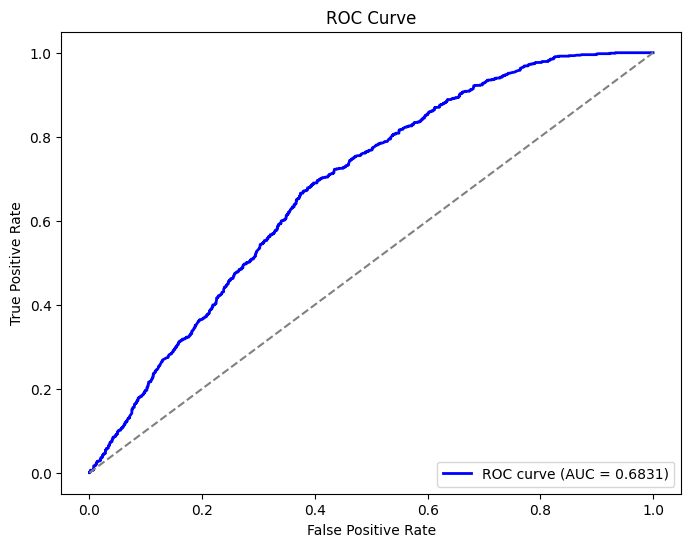

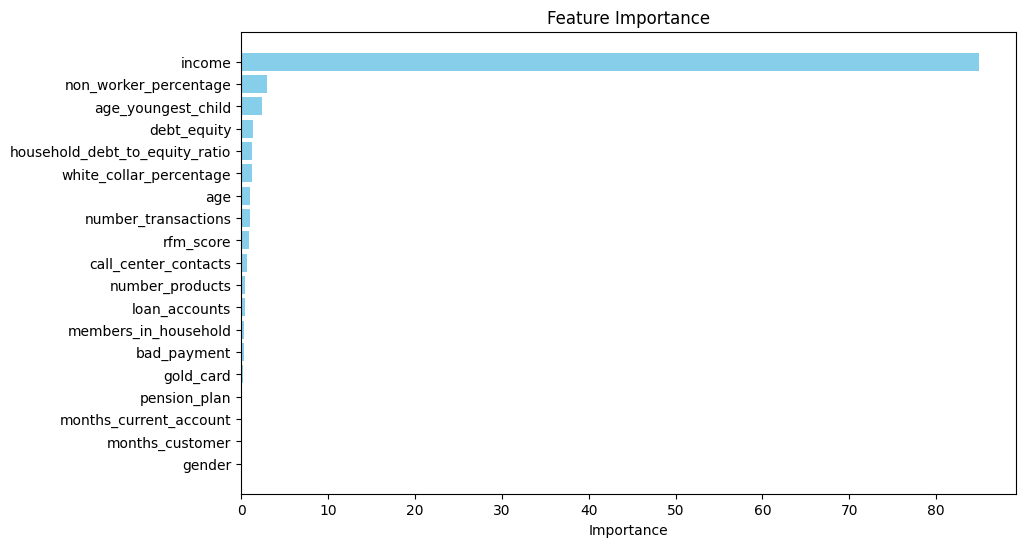

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def reduce_dimensionality(X_train, X_test, method="umap", n_components=2):
    if method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    elif method == "pca":
        reducer = PCA(n_components=n_components, random_state=42)
    else:
        raise ValueError("Method should be 'umap' or 'pca'")
    
    X_train_reduced = reducer.fit_transform(X_train)
    X_test_reduced = reducer.transform(X_test)
    
    return X_train_reduced, X_test_reduced

def filter_features(X_train, X_test, fi_df, threshold=0.01):
    important_features = fi_df[fi_df["Importance"] > threshold]["Feature"].values
    return X_train[important_features], X_test[important_features]

for target in target_cols:
    print(f"\n===== Эксперименты для {target} =====")
    X, y = prepare_data_for_target(data, target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for n_comp in [5, 10]:
        print(f"\nCatBoost на PCA ({n_comp} компонентов):")
        X_train_pca, X_test_pca = reduce_dimensionality(X_train, X_test, method="pca", n_components=n_comp)
        model_pca = train_catboost_model(X_train_pca, y_train, X_test_pca, y_test, cat_features=[])
        evaluate_catboost_model(model_pca, X_test_pca, y_test)
    
    print("\nCatBoost после удаления слабых фичей:")
    X_train_filtered, X_test_filtered = filter_features(X_train, X_test, fi_df, threshold=0.01)
    model_filtered = train_catboost_model(X_train_filtered, y_train, X_test_filtered, y_test, cat_features)
    evaluate_catboost_model(model_filtered, X_test_filtered, y_test)


===== Эксперименты для Mortgage =====

Оригинальная модель:
0:	learn: 0.6115665	test: 0.6102064	best: 0.6102064 (0)	total: 136ms	remaining: 1m 8s
250:	learn: 0.1680715	test: 0.1966647	best: 0.1961020 (120)	total: 25s	remaining: 24.8s
499:	learn: 0.1497926	test: 0.1984096	best: 0.1961020 (120)	total: 54.3s	remaining: 0us
bestTest = 0.1961020126
bestIteration = 120
Shrink model to first 121 iterations.
Accuracy: 0.8984
Precision: 0.6502
Recall: 0.5955
F1-score: 0.6216
Balanced Accuracy: 0.7716
AUC: 0.9444
LogLoss: 0.1961


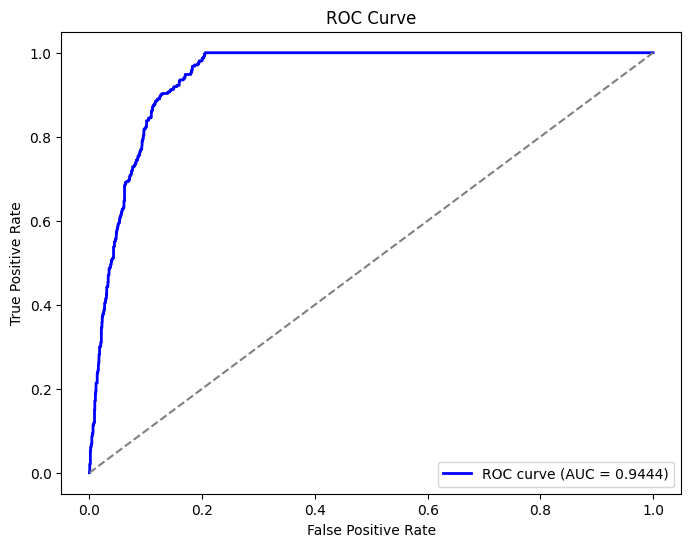

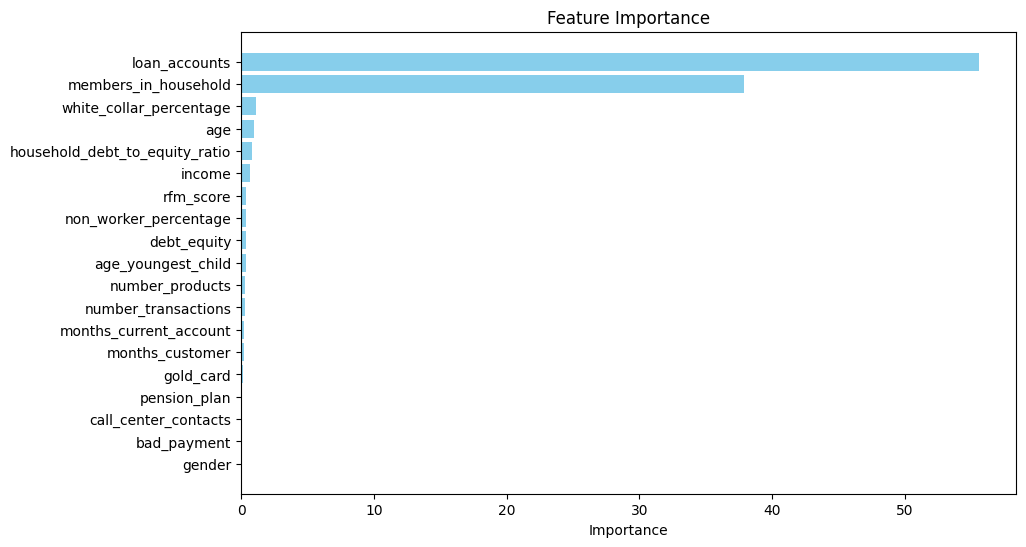


CatBoost после удаления важных фичей:
0:	learn: 0.6265337	test: 0.6255870	best: 0.6255870 (0)	total: 40.3ms	remaining: 20.1s
250:	learn: 0.1760230	test: 0.1957210	best: 0.1948005 (129)	total: 21.1s	remaining: 20.9s
499:	learn: 0.1645454	test: 0.1985669	best: 0.1948005 (129)	total: 48.4s	remaining: 0us
bestTest = 0.1948005105
bestIteration = 129
Shrink model to first 130 iterations.
Accuracy: 0.8952
Precision: 0.6373
Recall: 0.5858
F1-score: 0.6105
Balanced Accuracy: 0.7657
AUC: 0.9446
LogLoss: 0.1948


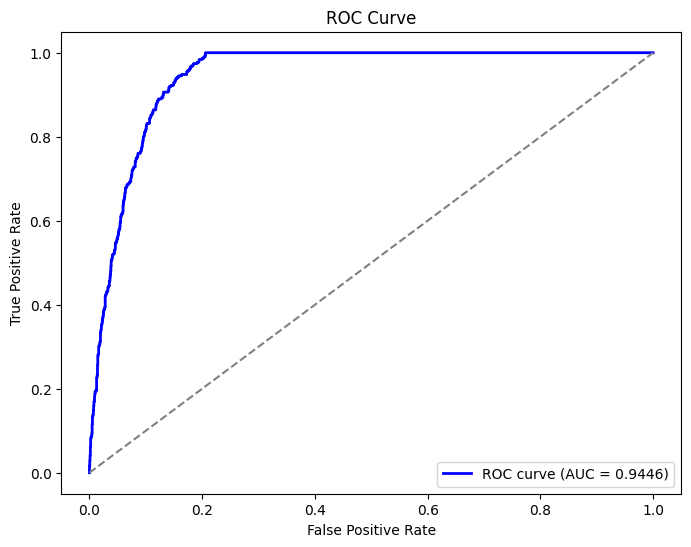

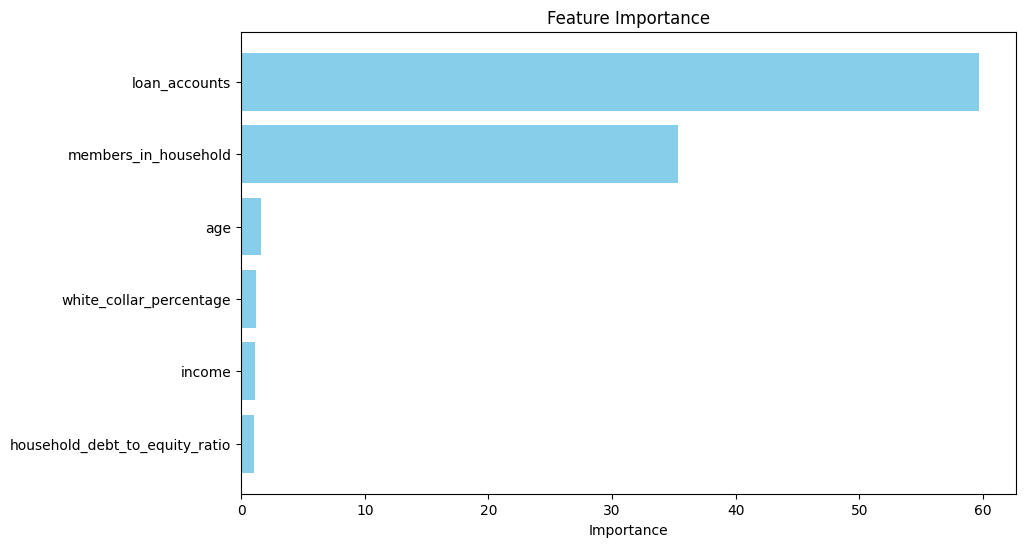


===== Эксперименты для Pension =====

Оригинальная модель:
0:	learn: 0.6602783	test: 0.6610367	best: 0.6610367 (0)	total: 50ms	remaining: 25s
250:	learn: 0.3890216	test: 0.4411921	best: 0.4381766 (101)	total: 26.1s	remaining: 25.9s
499:	learn: 0.3594301	test: 0.4472892	best: 0.4381766 (101)	total: 57.6s	remaining: 0us
bestTest = 0.4381765629
bestIteration = 101
Shrink model to first 102 iterations.
Accuracy: 0.7737
Precision: 0.4800
Recall: 0.0726
F1-score: 0.1261
Balanced Accuracy: 0.5249
AUC: 0.7704
LogLoss: 0.4382


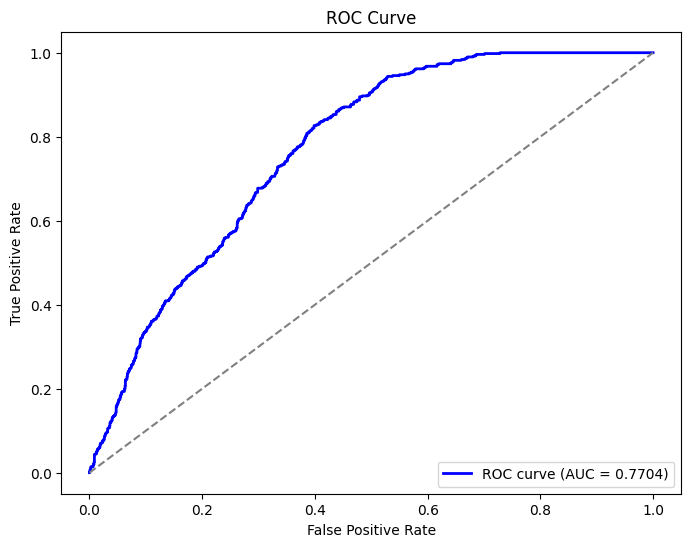

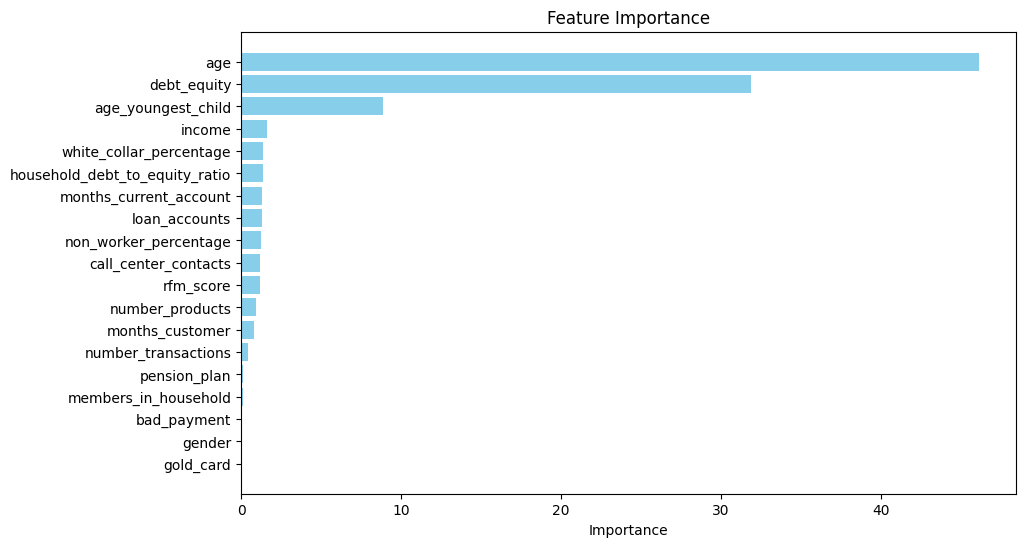


CatBoost после удаления важных фичей:
0:	learn: 0.6598995	test: 0.6608514	best: 0.6608514 (0)	total: 129ms	remaining: 1m 4s
250:	learn: 0.3910884	test: 0.4413180	best: 0.4374392 (121)	total: 27.3s	remaining: 27.1s
499:	learn: 0.3619154	test: 0.4482959	best: 0.4374392 (121)	total: 58.9s	remaining: 0us
bestTest = 0.437439214
bestIteration = 121
Shrink model to first 122 iterations.
Accuracy: 0.7719
Precision: 0.4578
Recall: 0.0766
F1-score: 0.1313
Balanced Accuracy: 0.5251
AUC: 0.7693
LogLoss: 0.4374


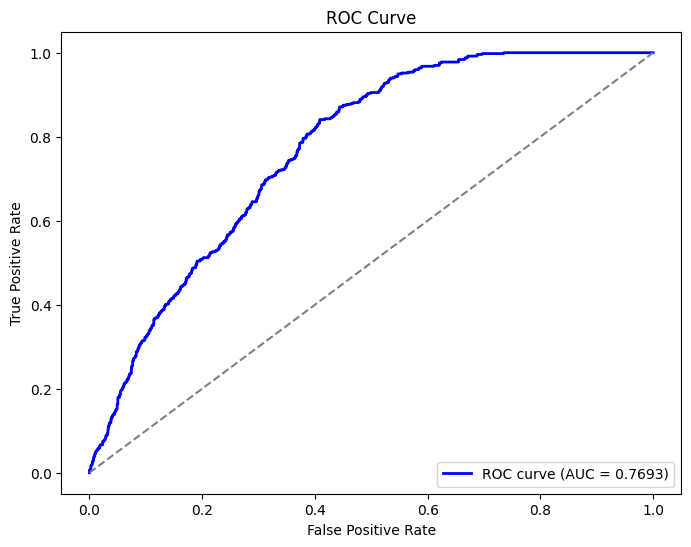

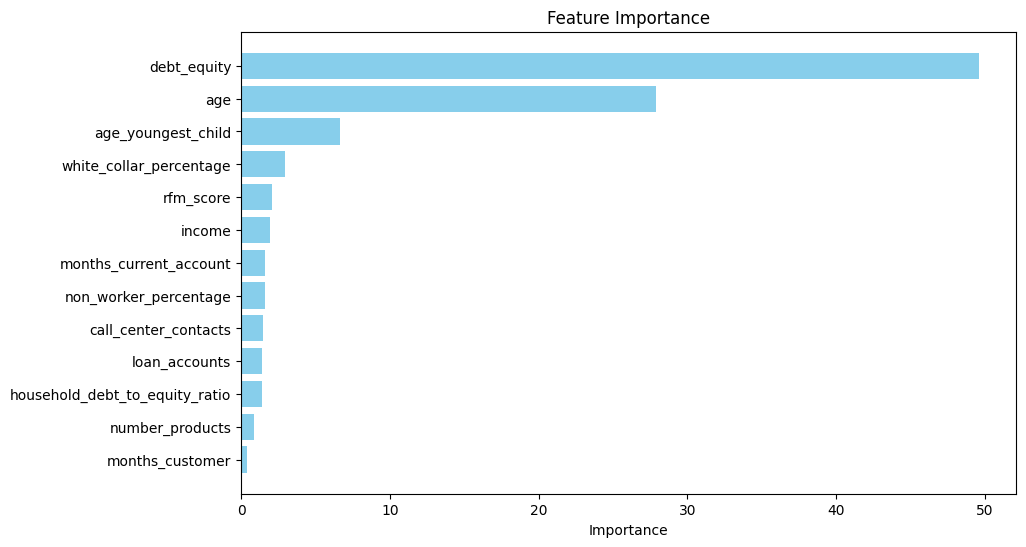


===== Эксперименты для Savings =====

Оригинальная модель:
0:	learn: 0.6860674	test: 0.6859962	best: 0.6859962 (0)	total: 131ms	remaining: 1m 5s
250:	learn: 0.5709065	test: 0.6130153	best: 0.6094468 (62)	total: 24.7s	remaining: 24.5s
499:	learn: 0.5537520	test: 0.6195355	best: 0.6094468 (62)	total: 56.1s	remaining: 0us
bestTest = 0.6094468028
bestIteration = 62
Shrink model to first 63 iterations.
Accuracy: 0.6281
Precision: 0.5432
Recall: 0.2997
F1-score: 0.3862
Balanced Accuracy: 0.5691
AUC: 0.6810
LogLoss: 0.6094


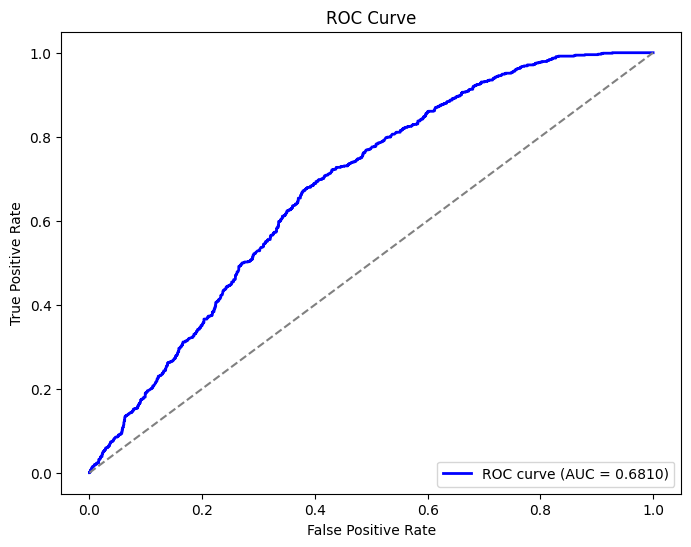

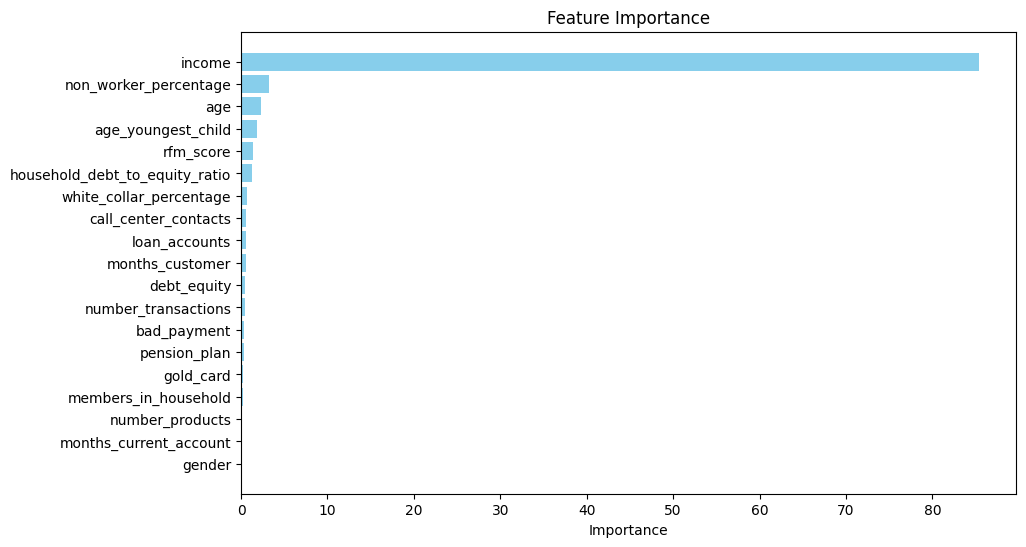


CatBoost после удаления важных фичей:
0:	learn: 0.6877506	test: 0.6876288	best: 0.6876288 (0)	total: 35.1ms	remaining: 17.5s
250:	learn: 0.5824246	test: 0.6112439	best: 0.6099519 (91)	total: 21.3s	remaining: 21.1s
499:	learn: 0.5679760	test: 0.6174496	best: 0.6099519 (91)	total: 46.7s	remaining: 0us
bestTest = 0.6099519137
bestIteration = 91
Shrink model to first 92 iterations.
Accuracy: 0.6268
Precision: 0.5477
Recall: 0.2532
F1-score: 0.3463
Balanced Accuracy: 0.5596
AUC: 0.6790
LogLoss: 0.6100


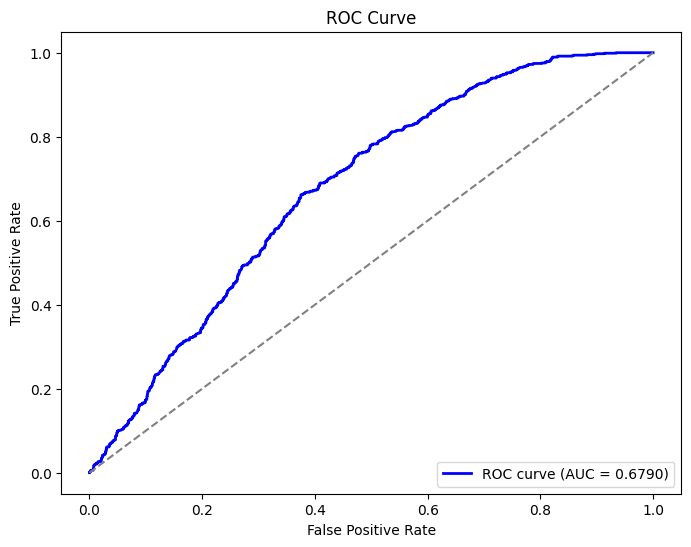

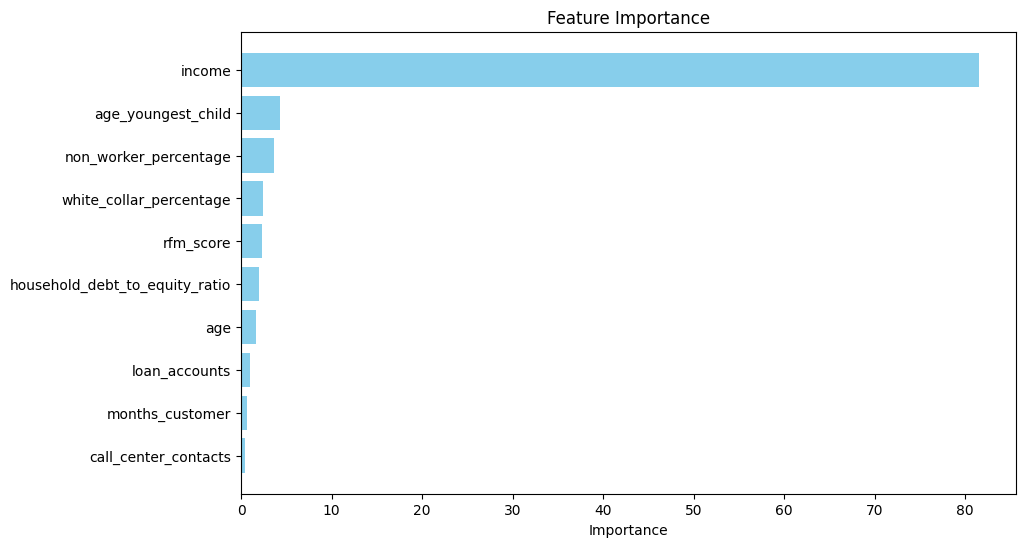

In [ ]:
import umap.umap_ as umap
import numpy as np
from sklearn.decomposition import PCA

def filter_features(X_train, X_test, fi_df, threshold=0.2, cat_features=None):
    important_features = fi_df[fi_df["Importance"] > threshold]["Feature"].values  
    remaining_features = [col for col in X_train.columns if col in important_features]  

    if cat_features is not None:
        cat_features = [col for col in cat_features if col in remaining_features]

    return X_train[remaining_features], X_test[remaining_features], cat_features

for target in target_cols:
    print(f"\n===== Эксперименты для {target} =====")
    X, y = prepare_data_for_target(data, target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print("\nОригинальная модель:")
    model = train_catboost_model(X_train, y_train, X_test, y_test, cat_features)
    metrics, fi_df = evaluate_catboost_model(model, X_test, y_test, feature_names=X.columns)
    
    print("\nCatBoost после удаления важных фичей:")
    X_train_filtered, X_test_filtered, cat_features_filtered = filter_features(
        X_train, X_test, fi_df, threshold=0.5, cat_features=cat_features
    )
    model_filtered = train_catboost_model(X_train_filtered, y_train, X_test_filtered, y_test, cat_features_filtered)
    evaluate_catboost_model(model_filtered, X_test_filtered, y_test)
